Epoch 0/1000, Loss: 25.847469329833984
Epoch 100/1000, Loss: 0.29556378722190857
Epoch 200/1000, Loss: 0.22968588769435883
Epoch 300/1000, Loss: 0.09530855715274811
Epoch 400/1000, Loss: 0.02364184334874153
Epoch 500/1000, Loss: 0.016443097963929176
Epoch 600/1000, Loss: 0.013322252780199051
Epoch 700/1000, Loss: 0.011138386093080044
Epoch 800/1000, Loss: 0.009356431663036346
Epoch 900/1000, Loss: 0.008189997635781765


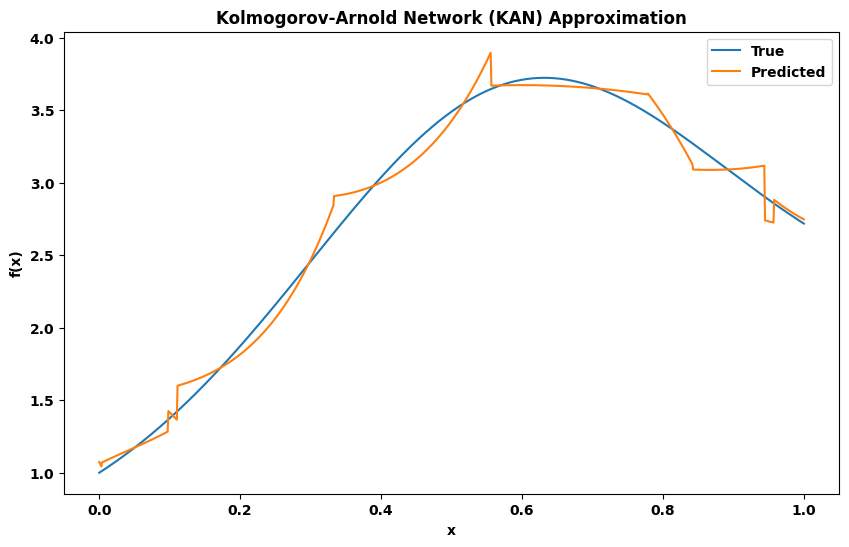

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class Spline(nn.Module):
    def __init__(self, num_knots):
        super(Spline, self).__init__()
        self.knots = nn.Parameter(torch.linspace(-1, 1, num_knots))
        self.coefficients = nn.Parameter(torch.randn(num_knots, 4))

    def forward(self, x):
        diff = x[:, None] - self.knots[None, :]
        indices = torch.sum(diff > 0, dim=1) - 1
        indices = torch.clamp(indices, 0, len(self.knots) - 2)

        coeffs = self.coefficients[indices]
        x_vals = torch.stack([x**i for i in range(4)], dim=-1)

        return torch.sum(coeffs * x_vals, dim=-1)




class KANLayer(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_knots):
        super(KANLayer, self).__init__()
        self.splines = nn.ModuleList([Spline(num_knots) for _ in range(num_inputs * num_outputs)])
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs

    def forward(self, x):
        outputs = torch.zeros((x.size(0), self.num_outputs))
        idx = 0
        for i in range(self.num_outputs):
            for j in range(self.num_inputs):
                outputs[:, i] += self.splines[idx](x[:, j])
                idx += 1
        return outputs

class KAN(nn.Module):
    def __init__(self, layer_shapes, num_knots):
        super(KAN, self).__init__()
        layers = []
        for i in range(len(layer_shapes) - 1):
            layers.append(KANLayer(layer_shapes[i], layer_shapes[i + 1], num_knots))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Example usage of KAN
def toy_function(x):
    return np.exp(np.sin(np.pi * x) + x ** 2)

# Generate data
x_train = np.linspace(0, 1, 1000)
y_train = toy_function(x_train)

# Convert to torch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

# Create and train the KAN
model = KAN([1, 2, 1], num_knots=10)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(x_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item()}")

# Plot the results
model.eval()
with torch.no_grad():
    y_pred = model(x_train_tensor).numpy()

plt.figure(figsize=(10, 6))
plt.plot(x_train, y_train, label="True")
plt.plot(x_train, y_pred, label="Predicted")
plt.legend()
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Kolmogorov-Arnold Network (KAN) Approximation")
plt.show()
